In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, norm, truncnorm, probplot
from sympy import symbols, Eq, solve

np.set_printoptions(threshold=np.inf)
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams["font.family"] = "Palatino" # Verdana
# plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 120

%config InlineBackend.figure_format = 'retina' # ipympl # inline
%load_ext autoreload
%autoreload 2

def read_data(file):
    flat_x = np.genfromtxt(file, delimiter=',', usecols=0)
    flat_y = np.genfromtxt(file, delimiter=',', usecols=1)
    flat_z = np.genfromtxt(file, delimiter=',', usecols=2)
    # flat_x = pd.read_csv('flat.csv', usecols=[0])
    # flat_z = np.delete(flat_z, np.argmin(flat_z))
    return flat_x, flat_y, flat_z

def n_rms(data, ODR): # g
    n_rms = np.std(data, axis=0) * 1 / 4096 # full-scale: 2 g
    print(f'Noise RMS: {n_rms*1000:.2f} mg')
    print(f'Resolution: {4*n_rms*1000:.2f} mg')
    print(f'PSD: {n_rms*10**6/np.sqrt(ODR):.2f} μg/√Hz')
    return n_rms

def b_eff(n_rms, range):
    snr_db = 20*np.log10(range/2*np.sqrt(2)/n_rms)
    b_eff = (snr_db - 1.76)/6.02
    print(f'Estimated SNR: {snr_db:.2f} dB')
    print(f'Effective Number of Bits: {b_eff:.2f}')
    return snr_db, b_eff

def theta_std(theta): # find std at an angle
    y_std = z_std = 4.8
    yz = -np.tan(np.deg2rad(theta))
    z = symbols('z')
    z = float(solve(Eq(4096**2, z**2 + (z*yz)**2), z)[1]) # take positive
    y = float(yz*z)
    yz_std = np.abs(-y/z)*np.sqrt((y_std/-y)**2+(z_std/z)**2)
    t_std = np.rad2deg(yz_std/(1+(-y/z)**2))
    return t_std

print(theta_std(45)) # expect 0.067

0.06714349161689334


In [2]:
# [COND]_[DR]_[LNOISE][F_READ]_[MODS].csv
# DR="000"; LNOISE="0"; F_READ="0"; MODS="00" # 800 Hz, NORM mode
# DR="000"; LNOISE="1"; F_READ="0"; MODS="00" # 800 Hz, NORM mode (low noise)
DR="100"; LNOISE="1"; F_READ="0"; MODS="00" # 50 Hz, NORM mode (low noise)
# DR="101"; LNOISE="1"; F_READ="0"; MODS="01" # 12.5 Hz, LNLP mode (low noise)

ODR = {
    "000": 800,
    "001": 400,
    "010": 200,
    "011": 100,
    "100": 50,
    "101": 12.5,
    "110": 6.25,
    "111": 1.56
}

file = f'flat_{DR}{LNOISE}{F_READ}_{MODS}.csv' # flat.csv
flat_x, flat_y, flat_z = read_data(file)

NOISE = n_rms(flat_x, ODR[DR]) # g
_, BEFF = b_eff(NOISE, 2)
# print(f"Min. Z-axis Acceleration @ {np.argmin(flat_z)}")

Noise RMS: 0.70 mg
Resolution: 2.82 mg
PSD: 99.66 μg/√Hz
Estimated SNR: 66.05 dB
Effective Number of Bits: 10.68


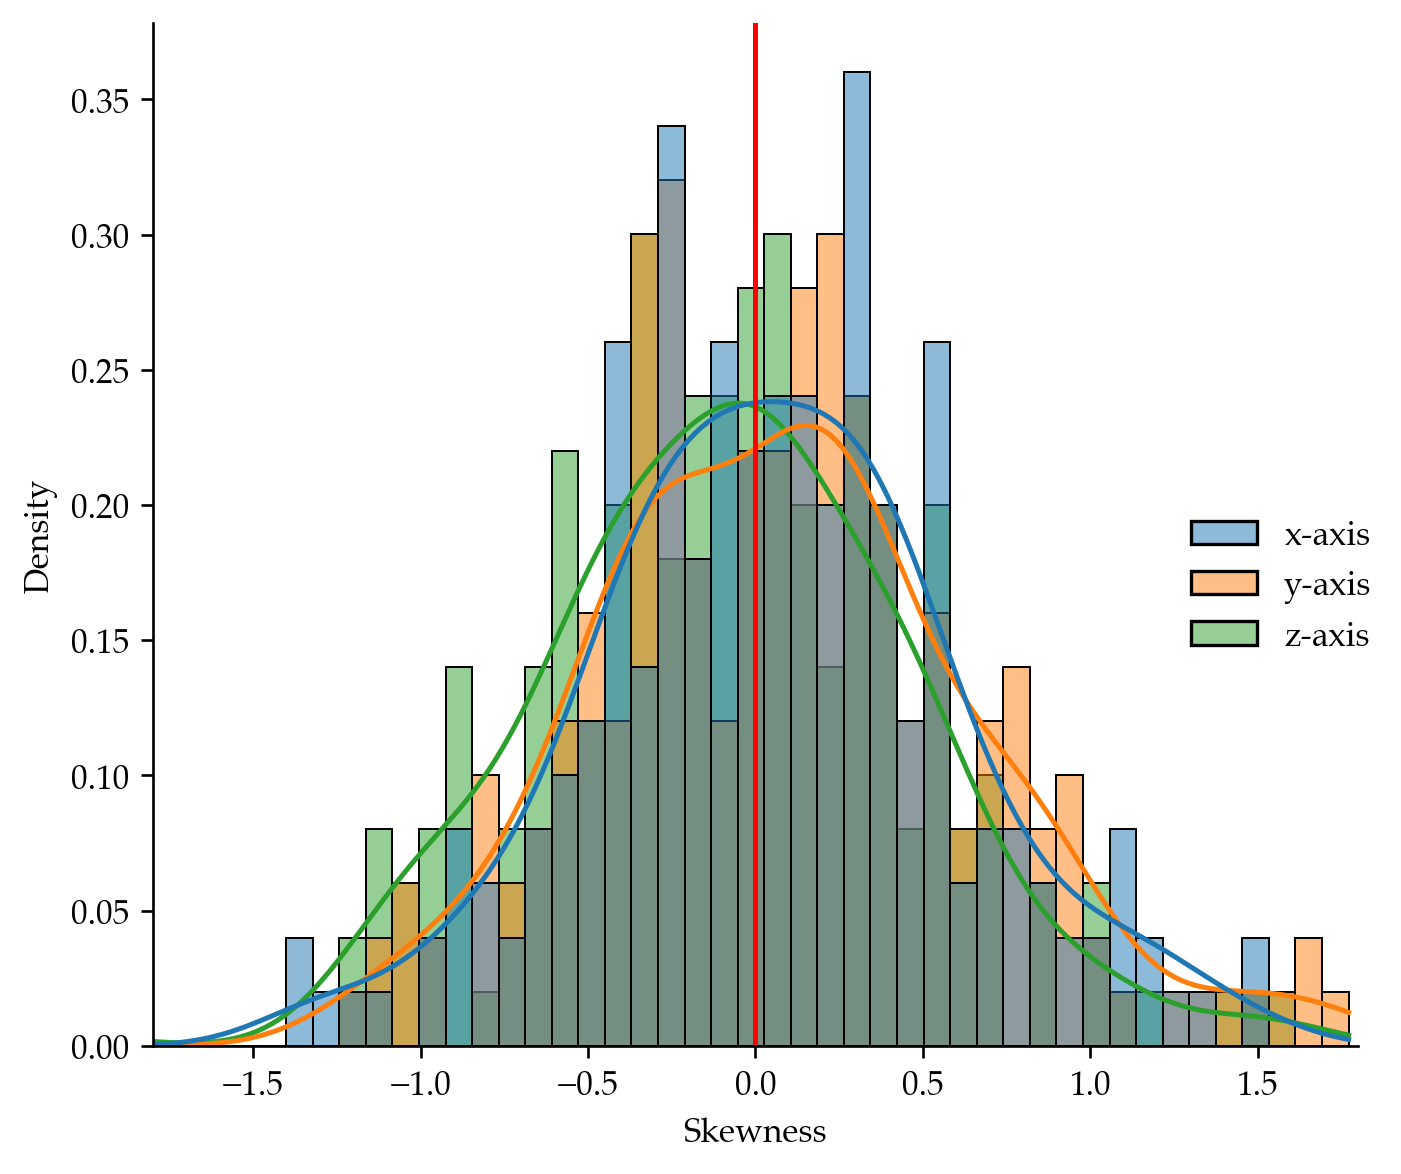

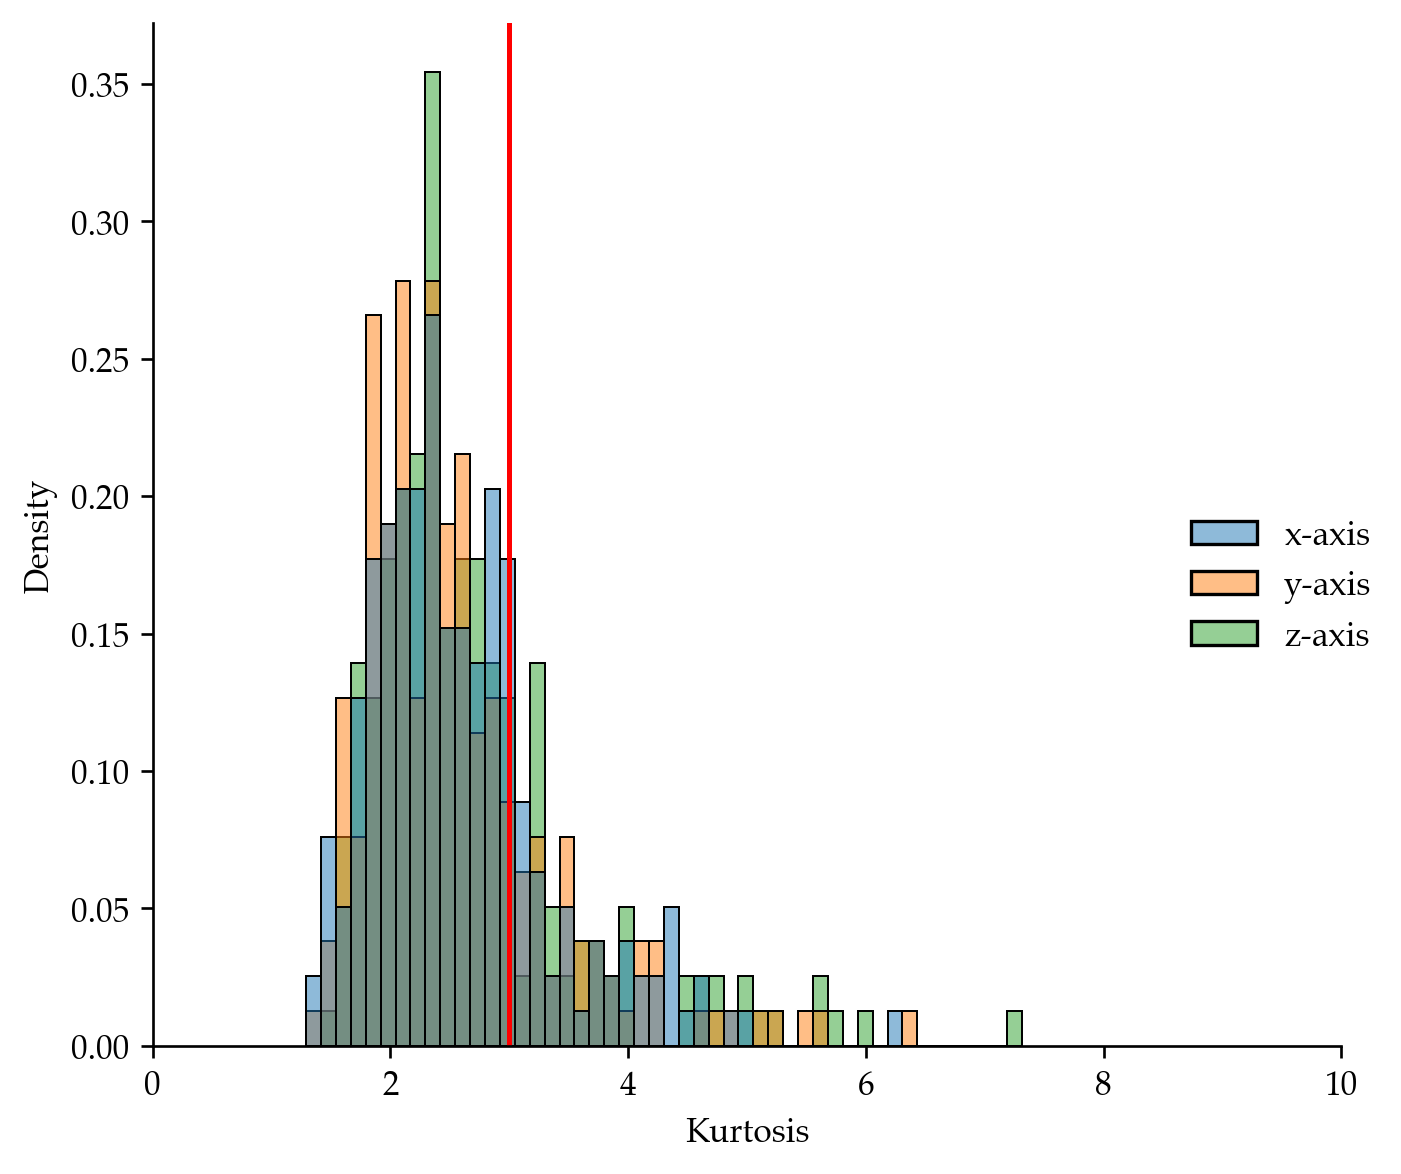

In [3]:
flat_xf = [flat_x[i:i+32] for i in range(0, len(flat_x), 30)]
flat_yf = [flat_y[i:i+32] for i in range(0, len(flat_y), 30)]
flat_zf = [flat_z[i:i+32] for i in range(0, len(flat_z), 30)]

skew_x = [skew(f) for f in flat_xf]
skew_y = [skew(f) for f in flat_yf]
skew_z = [skew(f) for f in flat_zf]

skew_set = pd.DataFrame({'x-axis': skew_x, 'y-axis': skew_y, 'z-axis': skew_z})
sns.displot(data=skew_set, kind='hist', bins=48, kde=True, legend=True, stat="density")
plt.xlim(-1.8, 1.8); plt.xlabel(f'Skewness'); plt.axvline(0, color='r', linestyle='-', label='Gaussian')
plt.tight_layout(); plt.savefig('skewness.svg')

kurt_x = [kurtosis(f, fisher=False) for f in flat_xf]
kurt_y = [kurtosis(f, fisher=False) for f in flat_yf]
kurt_z = [kurtosis(f, fisher=False) for f in flat_zf]
kurt_set = pd.DataFrame({'x-axis': kurt_x, 'y-axis': kurt_y, 'z-axis': kurt_z})
sns.displot(data=kurt_set, kind='hist', kde=False, legend=True, bins=48, stat="density")
plt.xlim(0, 10); plt.xlabel(f'Kurtosis'); plt.axvline(3, color='r', linestyle='-', label='Gaussian') # plt.subplots_adjust(bottom=0); 
plt.tight_layout(); plt.savefig('kurtosis.svg')

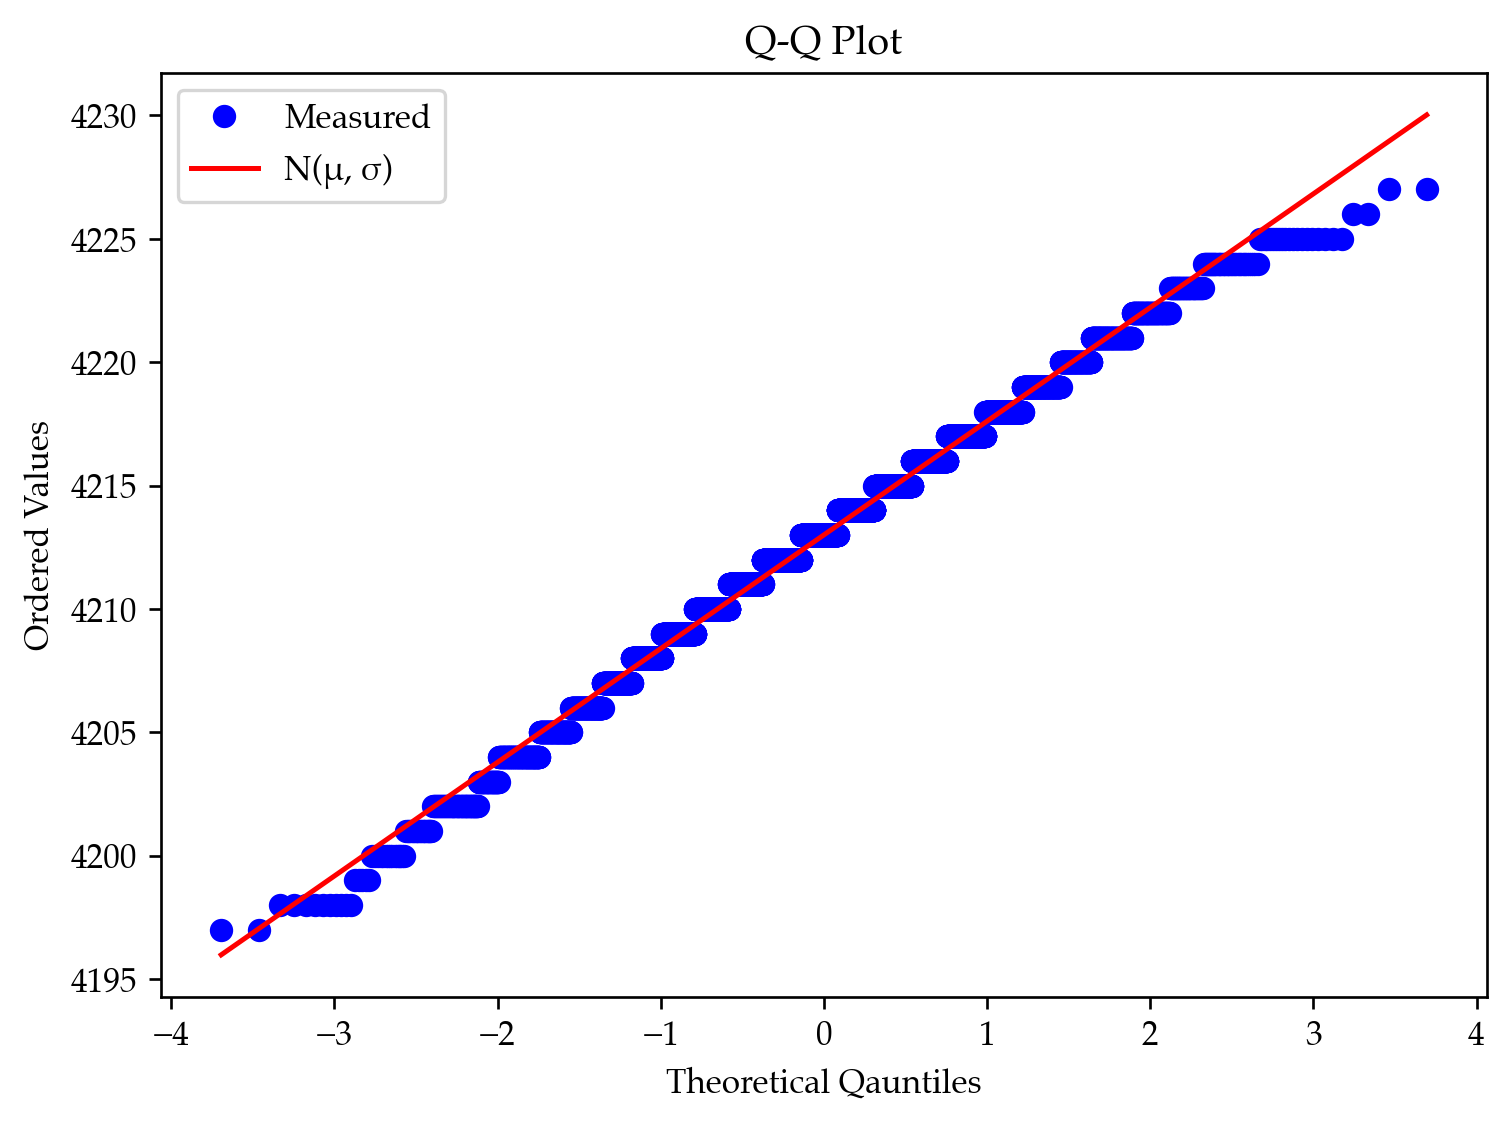

In [4]:
def plot_dist(data, label):
    sns.displot(data=data, kind='hist', stat="density", kde=True, line_kws={"lw": 4}, legend=False, label='Measured')
    # mean = np.mean(data); std = float(np.std(data, axis=0))
    mean, std = norm.fit(data)
    plt.xlabel(f'{label}')
    plt.axvline(mean, color='r', linestyle='-', lw=2, label=f'μ = {mean:.2}')
    plt.axvline(mean-std, color='r', linestyle='--', label=f'μ ± σ')
    plt.axvline(mean+std, color='r', linestyle='--')
    plt.legend(); plt.tight_layout()
    return mean, std

def plot_norm(data, label):
    mean, std = plot_dist(data, label)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std)
    plt.plot(x, p, 'k', linewidth=2, label=f'N(μ, σ)')
    plt.legend()
    return mean, std

plot_norm(flat_z, 'Acceleration (z-axis)'); plt.savefig('normplot.svg'); plt.show()
_ = probplot(flat_z, dist="norm", fit=True, plot=plt); plt.title('Q-Q Plot'); plt.legend(['Measured', 'N(μ, σ)']); plt.xlabel('Theoretical Qauntiles')
plt.tight_layout(); plt.savefig('qqplot.svg')

### Raise to Wake

-28.0, -134.0, 4215.0, 1.82, -0.38, PU
-27.0, -134.0, 4215.0, 1.82, -0.37, PU


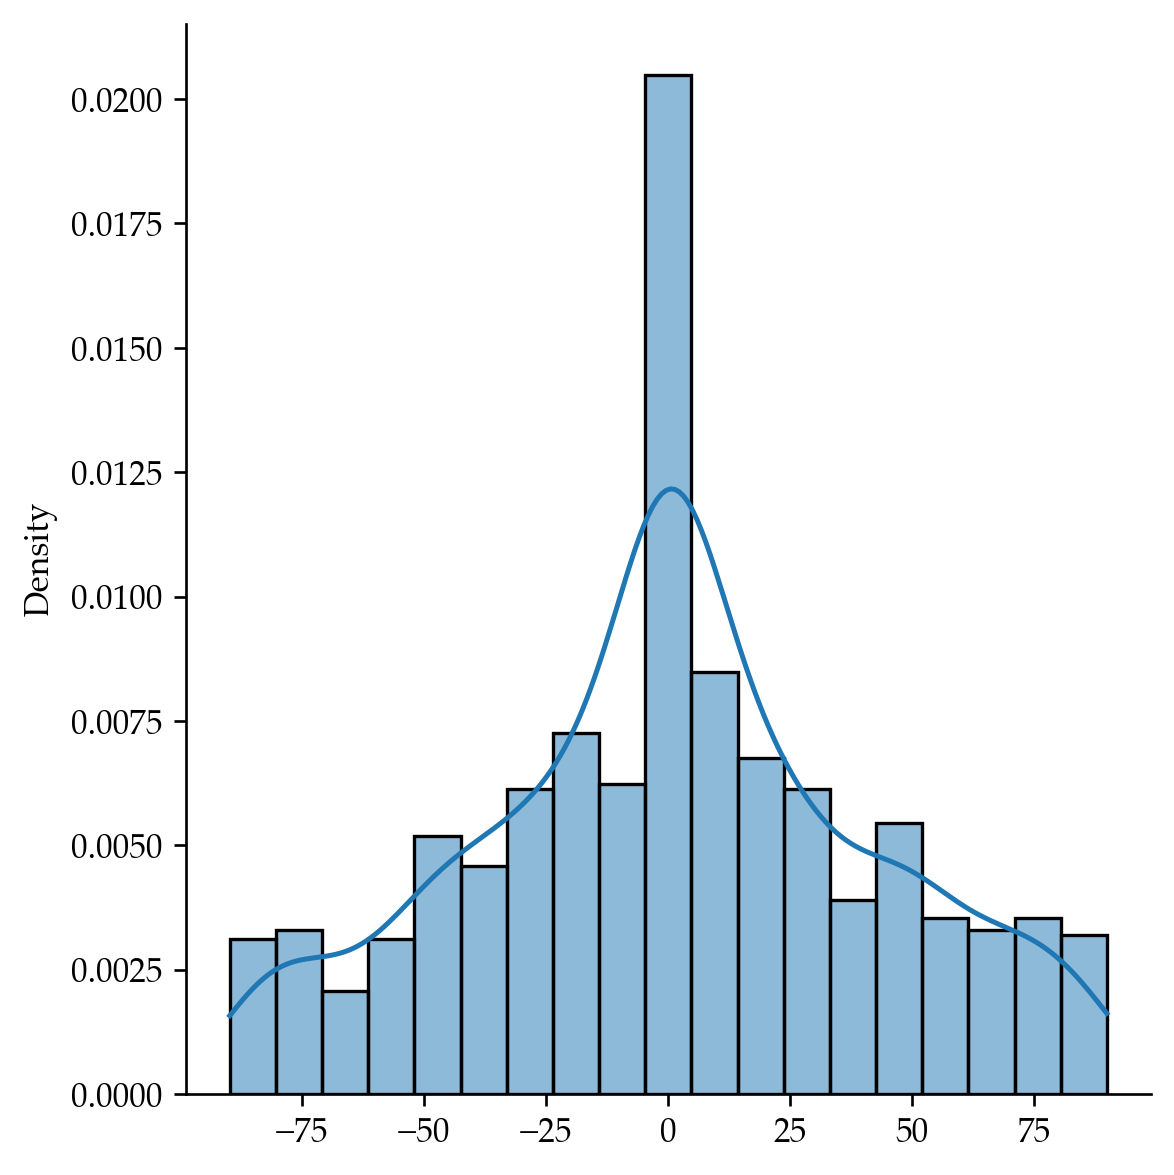

In [106]:
def read_data(file):
    x = np.genfromtxt(file, delimiter=', ', usecols=0)
    y = np.genfromtxt(file, delimiter=', ', usecols=1)
    z = np.genfromtxt(file, delimiter=', ', usecols=2)
    irq = np.genfromtxt(file, delimiter=',', usecols=3)
    zl = np.genfromtxt(file, delimiter=', ', usecols=4, dtype=str)
    pl = np.genfromtxt(file, delimiter=', ', usecols=5, dtype=str)
    fb = np.genfromtxt(file, delimiter=', ', usecols=6, dtype=str)
    return x, y, z, irq, zl, pl, fb

x, y, z, irq, zl, pl, fb = read_data('daq.csv')
theta = np.rad2deg(np.arctan(-y/z))
phi = np.rad2deg(np.arctan(x/np.sqrt(y**2+z**2)))
rho = np.rad2deg(np.arccos(z/np.sqrt(x**2+y**2+z**2)))
sns.displot(data=theta, kind='hist', kde=True, stat="density")
for i in range(len(irq))[10:12]:
    print(f'{x[i]}, {y[i]}, {z[i]}, {theta[i]:.2f}, {phi[i]:.2f}, {pl[i]}')

x-axis: 14.97 ± 2.89
y-axis: -43.57 ± 3.66
z-axis: 4213.00 ± 4.62


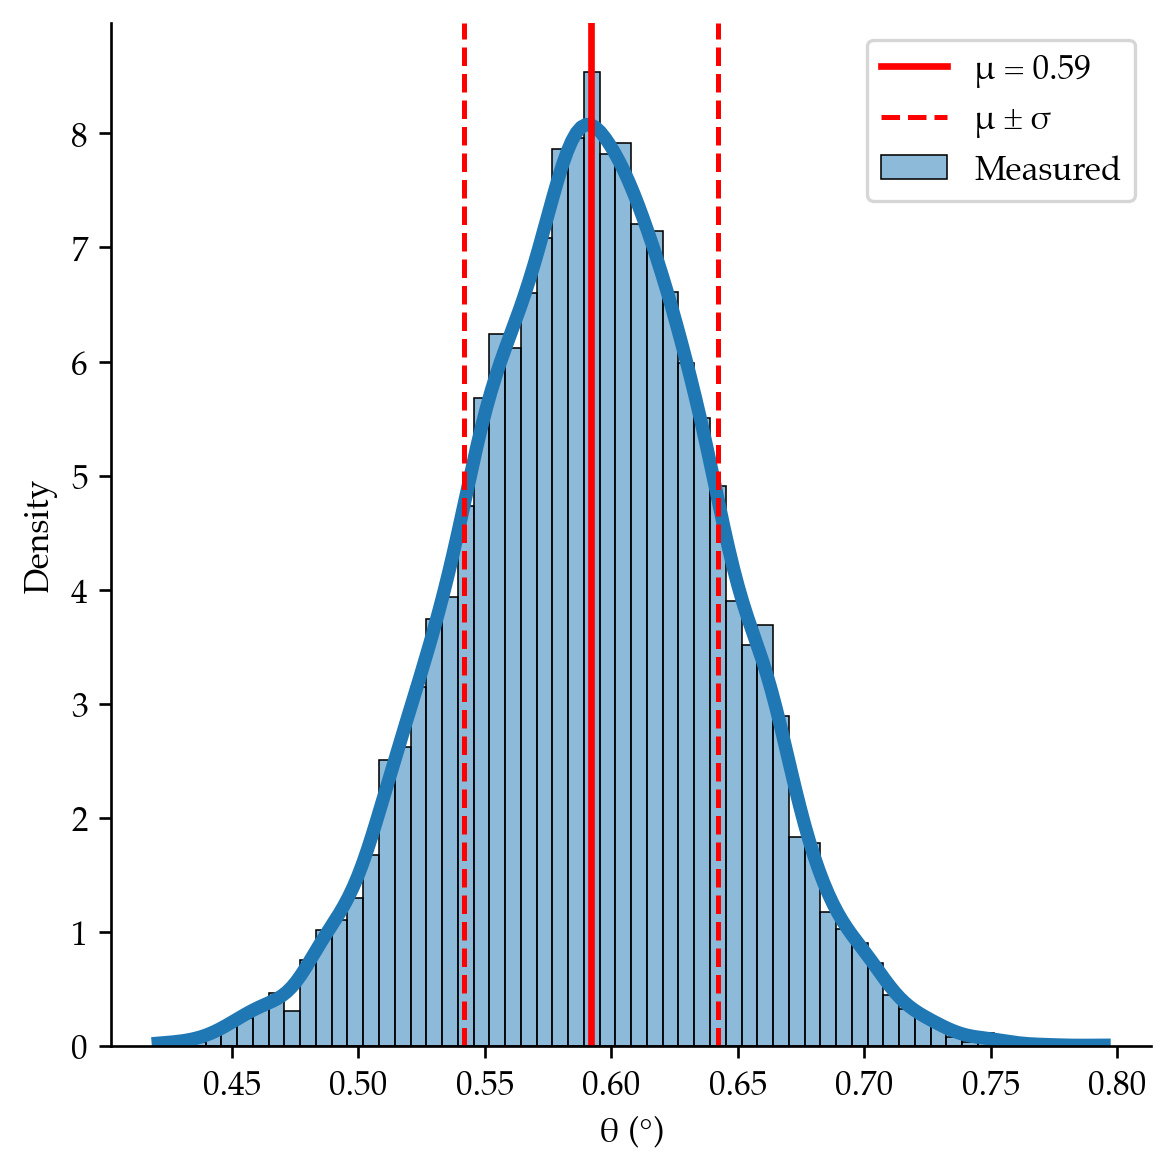

In [25]:
res = {'x': {'flat': flat_x}, 'y': {'flat': flat_y}, 'z': {'flat': flat_z}}
for i in res:
    res[i]['mean'], res[i]['std'] = norm.fit(res[i]['flat'])
    res[i]['random'] = np.random.normal(loc=res[i]['mean'], scale=res[i]['std'], size=9999)
    print(f'{i}-axis: {res[i]["mean"]:.2f} ± {res[i]["std"]:.2f}')

theta = np.rad2deg(np.arctan(-res['y']['random']/res['z']['random']))
plot_dist(theta, 'θ (°)'); plt.show()

In [30]:
y_std=4.8; y_mean=1200
z_std=4.8; z_mean=2078
res['y']['random'] = np.random.normal(loc=y_mean, scale=y_std, size=99999)
res['z']['random'] = np.random.normal(loc=z_mean, scale=z_std, size=99999)

theta = np.rad2deg(np.arctan(-res['y']['random']/res['z']['random']))

yz_std = np.abs(-y_mean/z_mean)*np.sqrt((y_std/-y_mean)**2+(z_std/z_mean)**2)
t_std = np.rad2deg(yz_std/(1+(-y_mean/z_mean)**2))
print(f'{t_std:.2f} vs {norm.fit(theta)[1]:.2f}')

# _ = probplot(theta, dist="norm", fit=True, plot=plt)
_ = plot_norm(theta, 'θ (°)'); plt.savefig('theta_sim.svg'); plt.show(); 

0.11 vs 0.11


0.30 vs 0.31


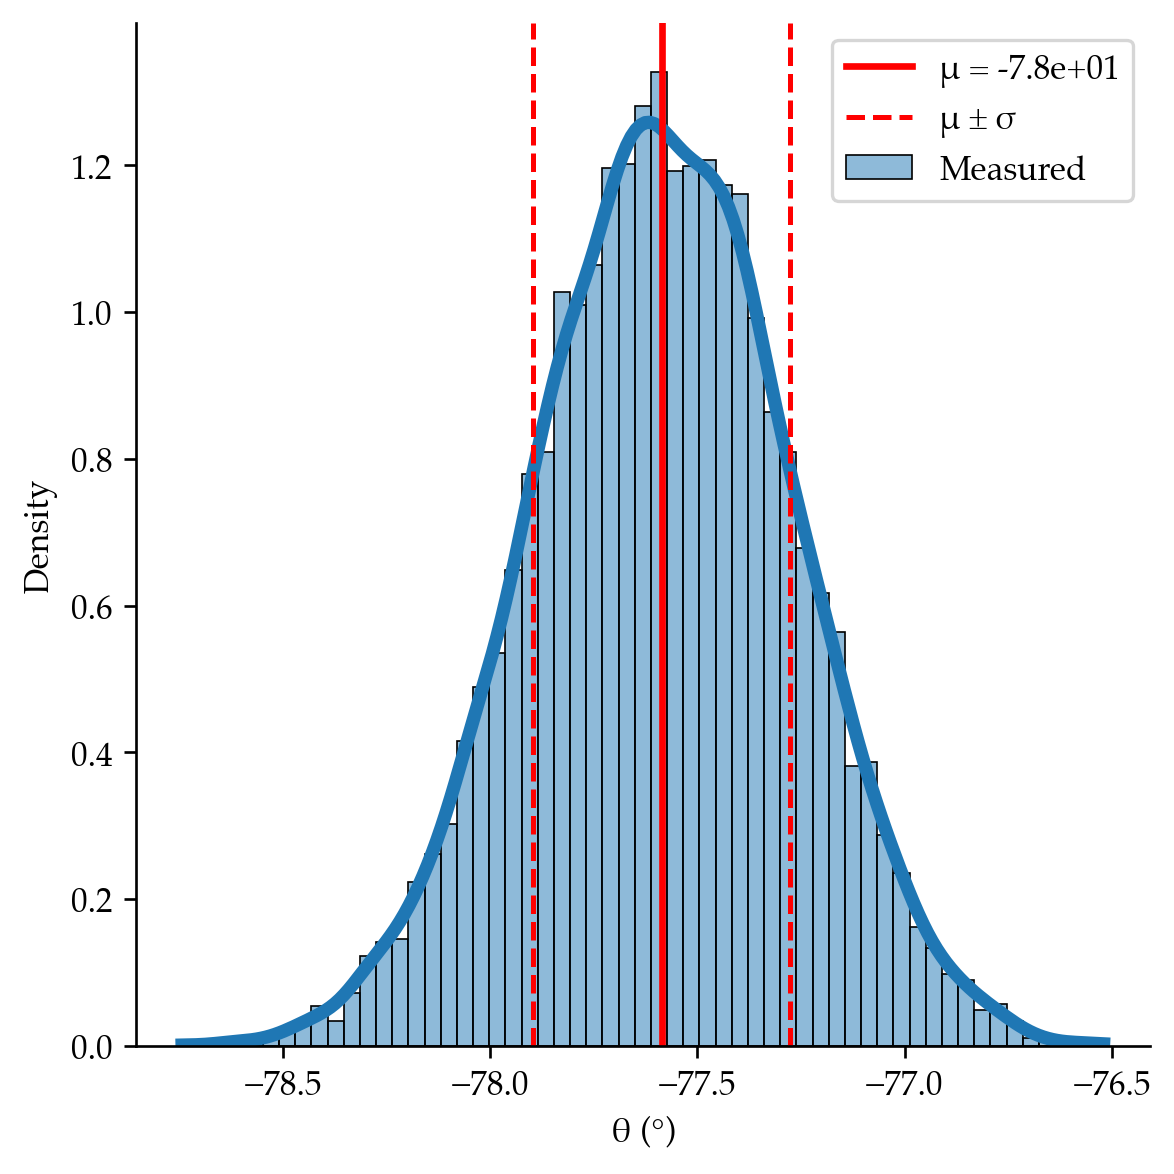

In [218]:
y_std=4.8; y_mean=4000
res['y']['random'] = np.random.normal(loc=y_mean, scale=y_std, size=9999)
res['z']['random'] = [ np.sqrt(4096**2 - i**2) if i <= 4096 else 0 for i in res['y']['random'] ]
z_mean, z_std = norm.fit(res['z']['random'])
theta = np.rad2deg(np.arctan(-res['y']['random']/res['z']['random']))

yz_std = np.abs(-y_mean/z_mean)*np.sqrt((y_std/-y_mean)**2+(z_std/z_mean)**2)
t_std = np.rad2deg(yz_std/(1+(-y_mean/z_mean)**2))
print(f'{t_std:.2f} vs {norm.fit(theta)[1]:.2f}')

# _ = probplot(theta, dist="norm", fit=True, plot=plt)
_ = plot_dist(theta, 'θ (°)'); plt.show()

In [ ]:
theta_1 = np.random.uniform(low=-14, high=14, size=9999) # 5s per 100 samples
theta_m1 = [np.random.normal(loc=i, scale=theta_std(i), size=1)[0] for i in theta_1]
sim_1 = {'theta': theta_1, 'theta_m1': theta_m1}
with open('sim_1.pkl', 'wb') as f:
    pickle.dump(sim_1, f)

theta_2 = np.random.uniform(low=45, high=135, size=9999)
theta_m2 = [np.random.normal(loc=i, scale=theta_std(i), size=1)[0] for i in theta_2]
sim_2 = {'theta': theta_2, 'theta_m2': theta_m2}
with open('sim_2.pkl', 'wb') as f:
    pickle.dump(sim_2, f)

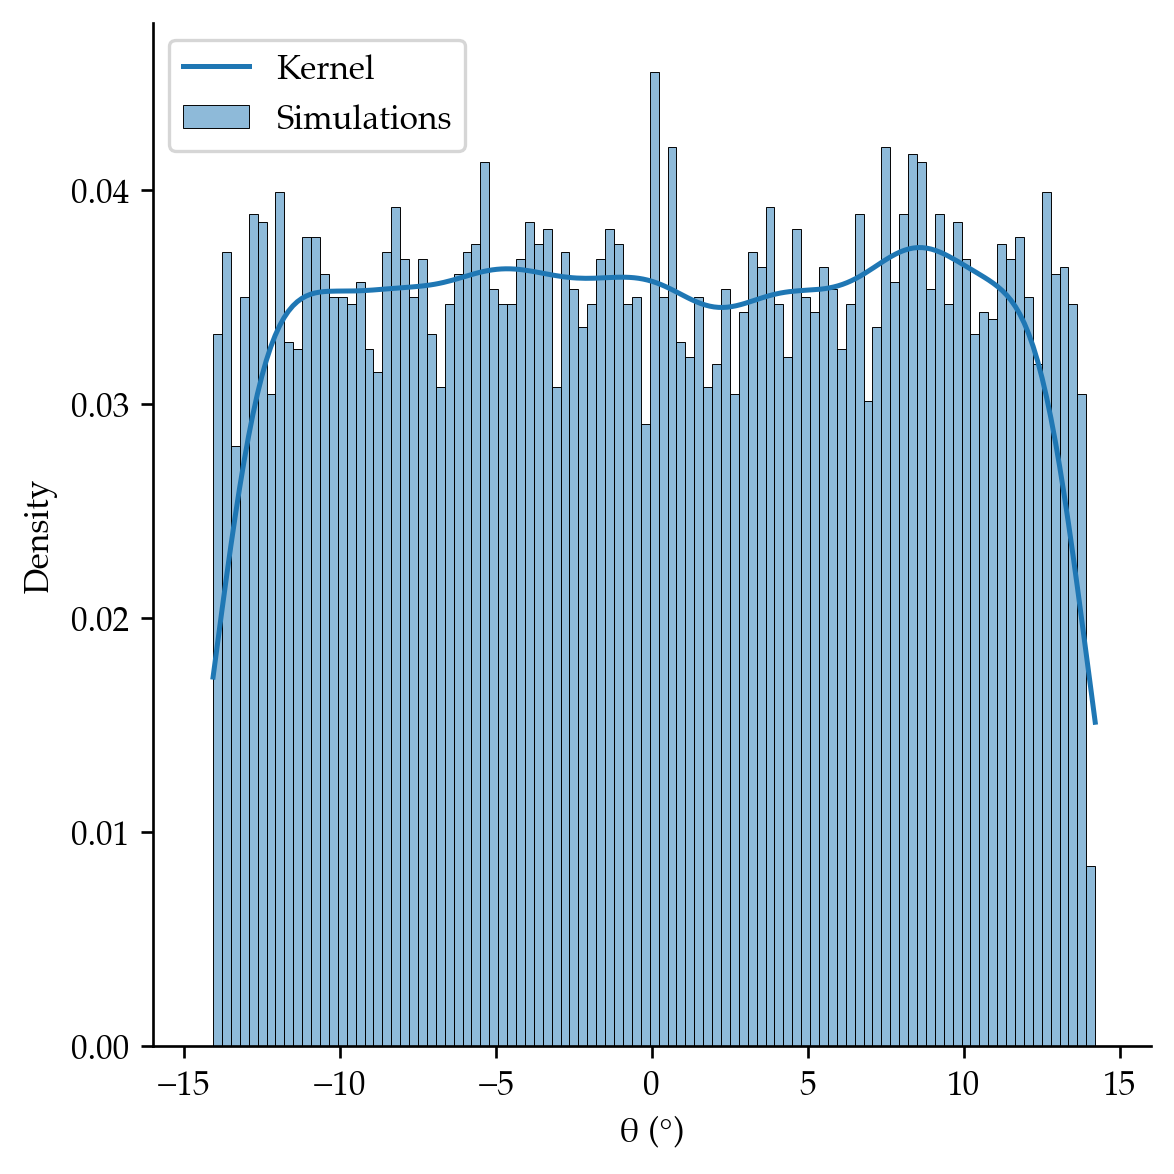

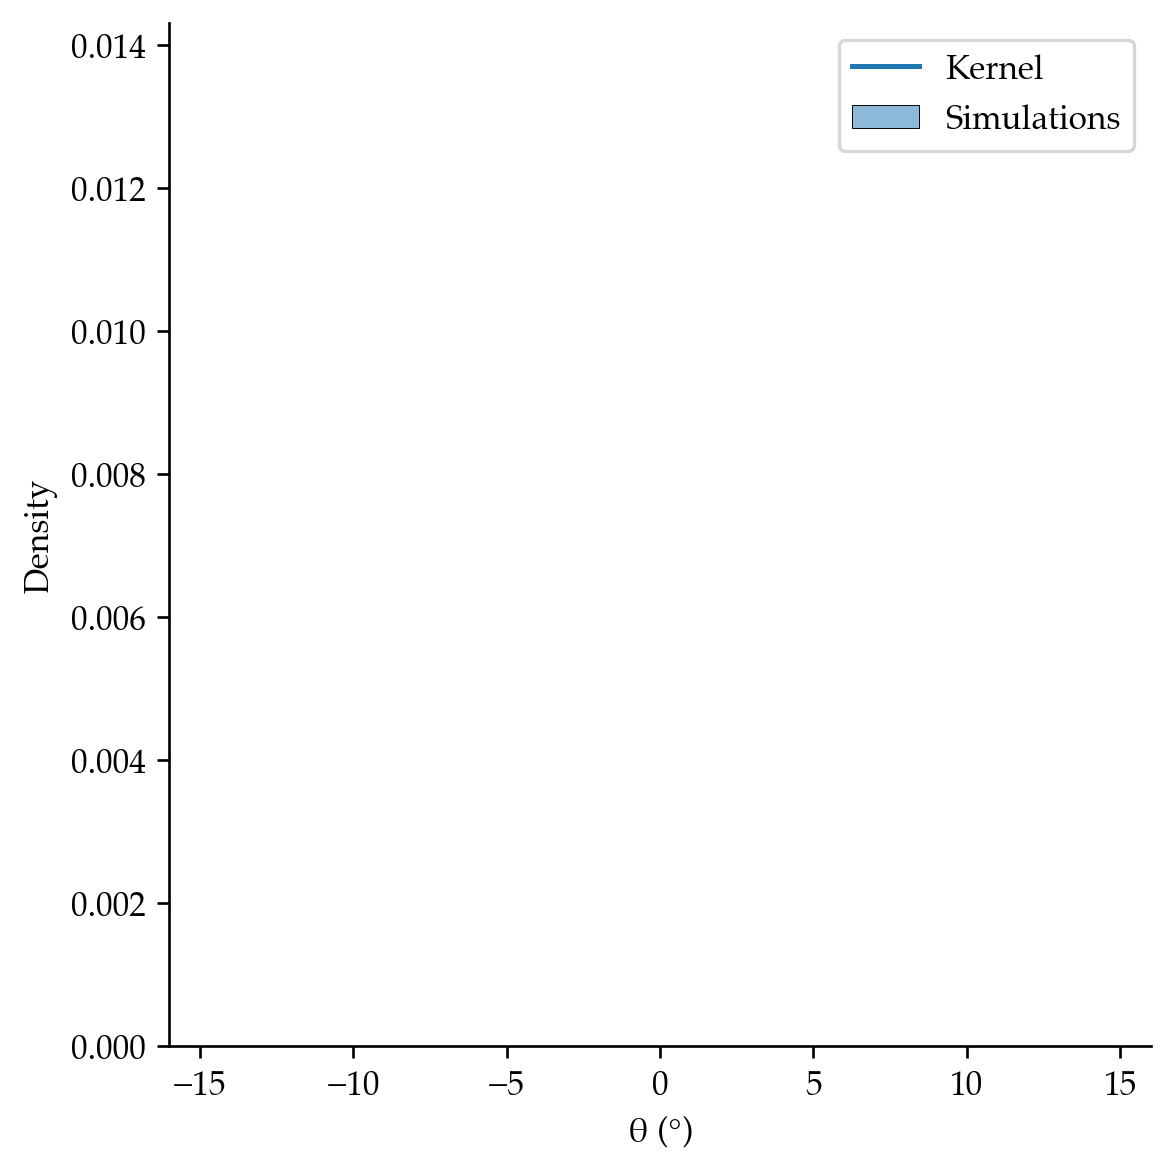

- Outliers 1: 19
Accuracy: 0.9981
- Outliers 2: 13
Accuracy: 0.9987


In [5]:
with open('sim_1.pkl', 'rb') as f: 
    sim_1 = pickle.load(f)
with open('sim_2.pkl', 'rb') as f: 
    sim_2 = pickle.load(f)

sns.displot(data=sim_1['theta_m1'], kind='hist', bins=99, kde=True, stat="density")
plt.xlabel('θ (°)'); plt.xlim(-16, 16)
plt.tight_layout(); plt.legend(['Kernel', 'Simulations'])
plt.savefig('sim_1.svg'); plt.show()
sns.displot(data=sim_2['theta_m2'], kind='hist', bins=99, kde=True, stat="density")
plt.xlabel('θ (°)'); plt.xlim(40, 140)
plt.tight_layout(); plt.legend(['Kernel', 'Simulations'])
plt.savefig('sim_2.svg'); plt.show()

out_1 = [ i for i in sim_1['theta_m1'] if i < -14 or i >= 14 ]
print(f'- Outliers 1: {len(out_1)}\nAccuracy: {1-len(out_1)/len(sim_1["theta_m1"]):.4f}')
out_2 = [ i for i in sim_2['theta_m2'] if i < 45 or i >= 135 ]
print(f'- Outliers 2: {len(out_2)}\nAccuracy: {1-len(out_2)/len(sim_2["theta_m2"]):.4f}')